## Model Agnostic Example

Currently we only support training full experiments with pytorch models and captum explanations. However, `ablation` can still be utilized to generate curves given a model and set of explanations. 

Below is an example that creates a new dataset, uses a `RandomForestClassifier` and generates explanations with `shap.TreeExplainer`

### Create Dataset

Datasets need to come with a few extra attributes to support categorical variables. We have a simple `NumpyDataset` class that holds all the necessary information. 

In [206]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from ablation.dataset import NumpyDataset

In [235]:
def prepare_german_data():
    """Prepare German dataset

    Returns:
        NumpyDataset: dataset
    """

    data = pd.read_csv("../ablation/data/MyGermanData.csv")
    X, y = data.drop("credit.rating", axis=1), data["credit.rating"]

    cat_ix = X.select_dtypes(include=["object"]).columns
    num_ix = X.select_dtypes(exclude=["object"]).columns

    X_train, X_test, y_train, y_test = train_test_split(X, y.values.flatten(), test_size=0.2)
    encoder = OneHotEncoder()
    scaler = StandardScaler()

    ct = ColumnTransformer(
        [("categoricals", encoder, cat_ix), ("numericals", scaler, num_ix)],
        remainder="passthrough",
        verbose_feature_names_out=False,
    )

    X_train = ct.fit_transform(X_train)
    X_test = ct.transform(X_test)

    return NumpyDataset(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        n_classes=2,
        feature_names=list(ct.get_feature_names_out()),
        original_feature_names=cat_ix.tolist() + num_ix.tolist(),
    )

In [236]:
dataset = prepare_german_data()

### Model Fit

In [237]:
from sklearn.ensemble import RandomForestClassifier

In [238]:
rf = RandomForestClassifier().fit(dataset.X_train, dataset.y_train)

### Generate Explanations

In [239]:
from shap import TreeExplainer

In [240]:
te = TreeExplainer(rf)
shap_values = te.shap_values(dataset.X_test)[0]

### Run Ablation

In [241]:
import seaborn as sns
import matplotlib.pyplot as plt
from ablation.explanations import Explanations
from ablation.perturb import generate_perturbation_distribution
from ablation.ablation import Ablation

We need to wrap the explanations in order to move from onehot to aggregated categorical representations. 

In [242]:
explanations = Explanations(explanation_values=shap_values, agg_map=dataset.agg_map)

In [243]:
print(explanations.data("sparse").shape)
print(explanations.data("dense").shape)

(200, 61)
(200, 20)


Generate a perturbation distribution with a given method

In [244]:
perturbation = generate_perturbation_distribution(
    method="constant_median", X=dataset.X_train, X_obs=dataset.X_test
)

In [245]:
abtn = Ablation(
    perturbation,
    rf,
    dataset,
    dataset.X_test,
    dataset.y_test,
    explanations.data("sparse"),
    explanations.data("dense"),
    random_feat_idx=dataset.dense_random_feat_idx,
    scoring_methods=["auroc"],
    local=True,
)

result = abtn.ablate_features()

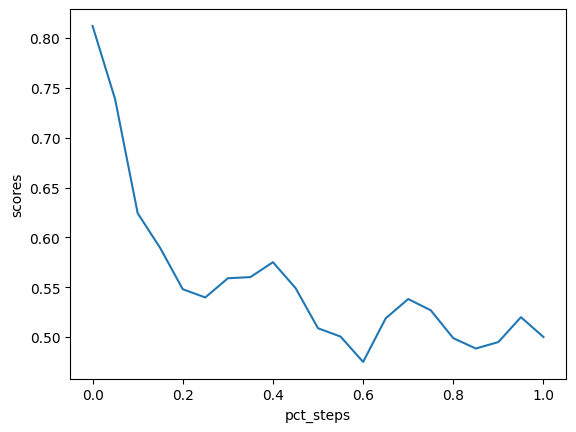

In [246]:
sns.lineplot(
    data=result,
    x="pct_steps",
    y="scores",
    palette="colorblind",
    legend=False,
)
plt.show()